In [18]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script for generic plots of ISSM output
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from scipy_io_utils import *

from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

import matplotlib.pyplot as plt
import numpy as np
import pickle

import pylab as pl


In [11]:
#filename = ''/efs/mpascual/SAtoES_hindcast_transient_low_retreat_end_member.nc'
#filename = './Models/SAtoES_hindcast_control_new_inversion_20222010.nc'
filename = './Models/SAtoES_hindcast_FA_Trial8.nc'

# Load model
md = loadmodel(filename, singleres='TransientSolution', resvars=['time', 'Thickness', 'Vel', 'MaskIceLevelset','IceVolumeAboveFloatation']) # , singletime=-1)

# Load glacier data
m = loadmat('./Cheat_matfiles/glacier0013.mat'); glacier0013 = m['glacier0013'];
m = loadmat('./Cheat_matfiles/glacier0052.mat'); glacier0052 = m['glacier0052'];
m = loadmat('./Cheat_matfiles/glacier0053.mat'); glacier0053 = m['glacier0053'];
m = loadmat('./Cheat_matfiles/glacier0090.mat'); glacier0090 = m['glacier0090'];

glaciers = [glacier0013, glacier0052, glacier0053, glacier0090]


Opening ./Models/SAtoES_hindcast_FA_Trial8.nc for reading 
empty init
solutionstep
solutionstep


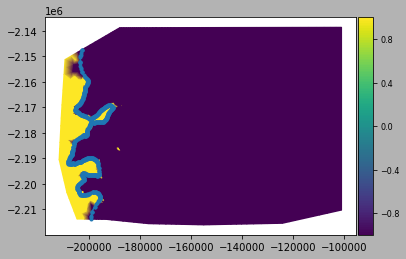

In [12]:
from contourlevelzero import contourlevelzero

contours = contourlevelzero(md, md.results.TransientSolution[-1].MaskIceLevelset, 0)

plotmodel(md, 'data', md.mask.ice_levelset)
plt.plot(contours[0]['x'], contours[0]['y'], '.-')


from expwrite import expwrite
#expwrite(contours[0], 'trial7_term_final.exp')


Text(0.5, 0, 'thickness change (m)')

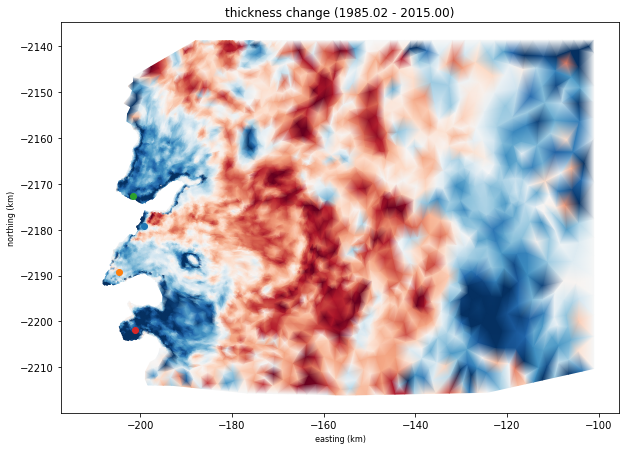

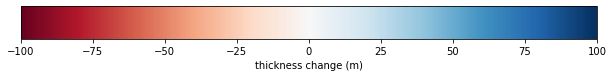

In [13]:
# Plot change in ice thickness
cmap = 'RdBu'

plot_step_start =  0
plot_step_end   = -1

thickness_change = md.results.TransientSolution[plot_step_end].Thickness - md.results.TransientSolution[plot_step_start].Thickness #md.geometry.thickness

fig = plt.figure(figsize=(10,10))
vmin = -100
vmax = +100
plotmodel(md, 'data', thickness_change, 'mask', md.results.TransientSolution[plot_step_end].MaskIceLevelset<=0, \
         'colormap', cmap, 'caxis', [vmin, vmax], 'colorbar', 'off', \
         'unit', 'km', 'xlabel', 'easting (km)', 'ylabel', 'northing (km)', \
         'backgroundcolor', 'white')

# for masking: 'mask#all', md.mask.ice_levelset<=0

plt.title('thickness change ({:6.2f} - {:6.2f})'.format(md.results.TransientSolution[plot_step_start].time[0], md.results.TransientSolution[plot_step_end].time[0]))

# Add glacier locations
# NOTE that we divide by 1000 to get units of km to match the plotmodel command above
for glacier in glaciers:
    plt.plot(glacier['x']/1000., glacier['y']/1000., 'o')
    
# Colorbar as a separate plot
a = np.array([[vmin,vmax]])
pl.figure(figsize=(10, 0.75))
img = pl.imshow(a, cmap=cmap)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation='horizontal', cax=cax)
pl.xlabel('thickness change (m)')


Text(0.5, 0, 'Velocity Change (m/yr)')

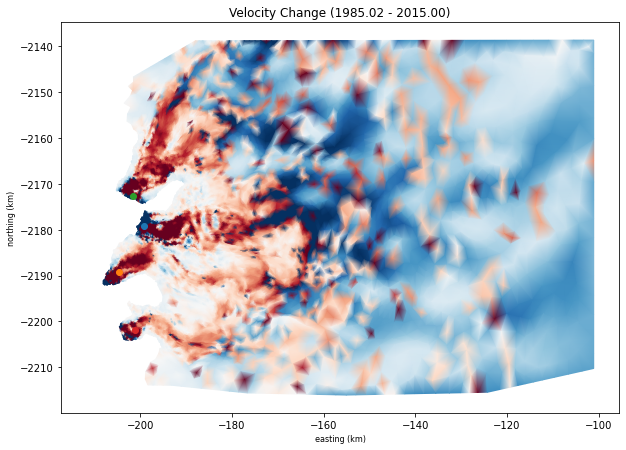

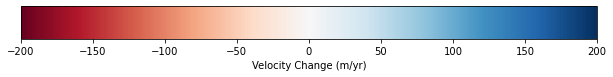

In [19]:
# Plot change in velocity
cmap = 'RdBu'

plot_step_start =  0
plot_step_end   = -1

velocity_change = md.results.TransientSolution[-1].Vel - md.initialization.vel

fig = plt.figure(figsize=(10,10))
vmin = -200
vmax = +200
plotmodel(md, 'data', velocity_change, 'mask', md.results.TransientSolution[-1].MaskIceLevelset<=0, \
         #'xlim', [-215, -160], 'ylim', [-2215, -2150], \
         'colormap', cmap, 'caxis', [vmin, vmax], 'colorbar', 'off', \
         'unit', 'km', 'xlabel', 'easting (km)', 'ylabel', 'northing (km)', \
         'backgroundcolor', 'white')
#plt.xlim(-215000, -190000)
#plt.ylim(-2210000, -2170000)

# for masking: 'mask#all', md.mask.ice_levelset<=0

plt.title('Velocity Change ({:6.2f} - {:6.2f})'.format(md.results.TransientSolution[plot_step_start].time[0], md.results.TransientSolution[plot_step_end].time[0]))

# Add glacier locations
# NOTE that we divide by 1000 to get units of km to match the plotmodel command above
for glacier in glaciers:
    plt.plot(glacier['x']/1000., glacier['y']/1000., 'o')
    
# Colorbar as a separate plot
a = np.array([[vmin,vmax]])
pl.figure(figsize=(10, 0.75))
img = pl.imshow(a, cmap=cmap)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation='horizontal', cax=cax)
pl.xlabel('Velocity Change (m/yr)')

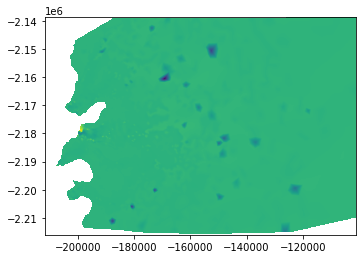

In [15]:
from scipy.interpolate import griddata

xstep = 100
ystep = 100
xi = np.arange(np.min(md.mesh.x),np.max(md.mesh.x),xstep)
yi = np.arange(np.min(md.mesh.y),np.max(md.mesh.y),ystep)

mask = md.results.TransientSolution[plot_step_end].MaskIceLevelset > 0
#thickness_change[mask] = np.nan
velocity_change[mask] = np.nan

xi,yi = np.meshgrid(xi,yi)
zi = griddata((md.mesh.x,md.mesh.y),velocity_change,(xi,yi),method='linear')

extent = [xi[0,0] + xstep/2, xi[0,-1] - xstep/2, yi[0,0] + ystep/2, yi[-1,0] - ystep/2]
plt.imshow(zi, extent=extent, origin='lower')

sys.path.append('/home/jovyan/scripts_and_utilities/pythonModules')
import raster

#raster.writeArrayAsRasterBand('trial6_vel_chg_mask.tif', raster.extent2gt(zi,extent), np.flipud(zi), -9999.)

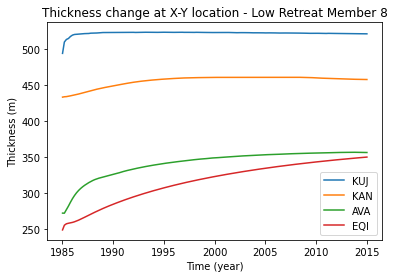

In [16]:
# Interpolate thickness from TransientSolution to glacier locations
from InterpFromMesh2d import InterpFromMesh2d

fig = plt.figure()
for glacier in glaciers:
    time = list()
    glacier_thickness = list()
    for i in range(len(md.results.TransientSolution)):
        thickness = InterpFromMesh2d(md.mesh.elements, md.mesh.x, md.mesh.y, md.results.TransientSolution[i].Thickness, \
                                     glacier['x'], glacier['y'])
        time.append(md.results.TransientSolution[i].time)
        glacier_thickness.append(thickness)
    
    plt.plot(time, glacier_thickness)
    plt.xlabel('Time (year)')
    plt.ylabel('Thickness (m)')
    plt.title('Thickness change at X-Y location - Low Retreat Member 8')
    plt.legend(["KUJ", "KAN", "AVA", "EQI"], loc ="lower right")
    
#fig.savefig('trial8_term_pos_timeseries.png', format='png', dpi=300)

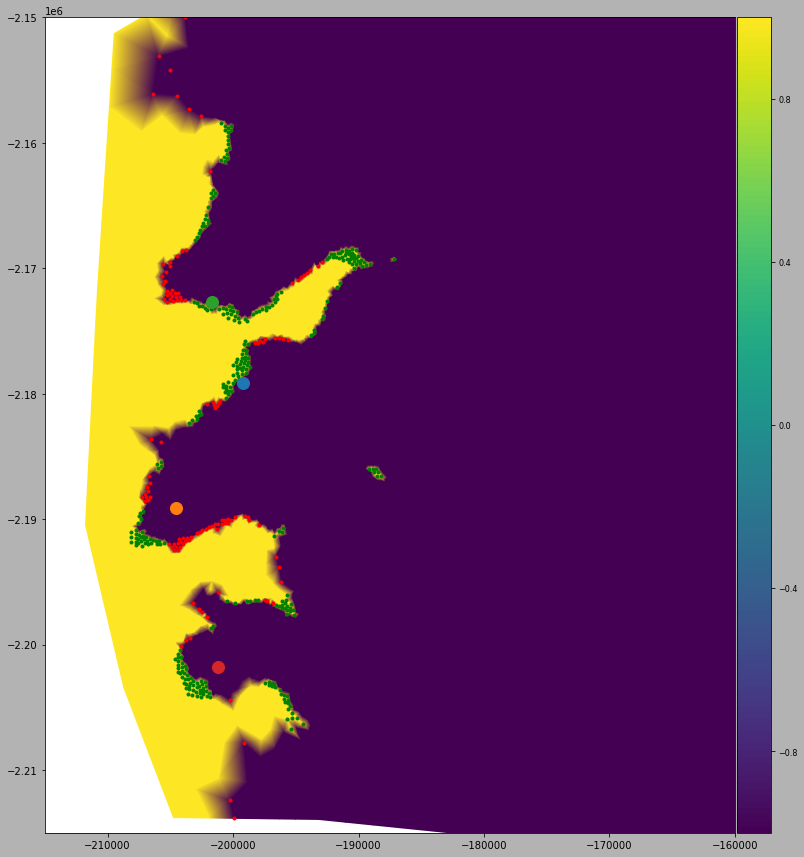

In [17]:
time = [md.results.TransientSolution[i].time for i in range(len(md.results.TransientSolution))]
VAF = [md.results.TransientSolution[i].IceVolumeAboveFloatation for i in range(len(md.results.TransientSolution))]

# Look for terminus advance
idx = np.logical_and(np.array(md.mask.ice_levelset) > 0, \
                     np.array(md.results.TransientSolution[-1].MaskIceLevelset).ravel() <= 0)
pos_advance = np.where(idx)[0]

# Look for terminus retreat
idx = np.logical_and(np.array(md.mask.ice_levelset) < 0, \
                     np.array(md.results.TransientSolution[-1].MaskIceLevelset).ravel() >= 0)
pos_retreat = np.where(idx)[0]

#fig = plt.figure(figsize=(10,10))
#plotmodel(md, 'data', np.array(md.mask.ice_levelset), \
#              'data', np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel(), \
#              'caxis#all', [-1., +1.])
#plotmodel(md, 'data', np.array(md.mask.ice_levelset) - np.array(md.results.TransientSolution[-1].MaskIceLevelset).ravel(), \
#              'caxis#all', [-1, +1])

fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', md.mask.ice_levelset)
plt.xlim(-215000, -160000)
plt.ylim(-2215000, -2150000)
plt.plot(md.mesh.x[pos_advance], md.mesh.y[pos_advance], 'g.')
plt.plot(md.mesh.x[pos_retreat], md.mesh.y[pos_retreat], 'r.')

for glacier in glaciers:
    plt.plot(glacier['x'], glacier['y'], 'o', markersize = 12)
    
#fig.savefig('model_set_up.png', format='png', dpi=300)

In [7]:
from plotdoc import plotdoc
plotdoc()

   Plot usage:  plotmodel(model, varargin)
   plotting is done with couples of keywords values, the type and style of data to display is given by one (or several) of the followings
   Options:  
     'data' :  and a model field or one of the following options.
 - quiver :   quiver plot give data and a vector array [Vx, Vy]
 - mesh :   draw mesh using trisurf
 - BC :   this will draw all the boundary conditions (Dirichlet and Neumann).
 - elementnumbering :   numbering of elements (matlab indices)
 - 3D disclaimer :  3D is implemented with plot3d for now this is not optimal and may change to mayavi at some point. The impelementation is on the development side for now so expect some issue and question your plotting before you results.

   The general look of the plot is then given by the following keywords
 - alpha :   set transparency of plotted data (in [0, 1]) 
 - axes_pad :   spacing between axes (default is 0.25)
 - axis :   show ('on') or hide ('off') axes
 - backgroundcolor :   pl